In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/cityscapes_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/cityscapes_data/val/302.jpg
/content/drive/MyDrive/cityscapes_data/val/180.jpg
/content/drive/MyDrive/cityscapes_data/val/360.jpg
/content/drive/MyDrive/cityscapes_data/val/344.jpg
/content/drive/MyDrive/cityscapes_data/val/396.jpg
/content/drive/MyDrive/cityscapes_data/val/143.jpg
/content/drive/MyDrive/cityscapes_data/val/281.jpg
/content/drive/MyDrive/cityscapes_data/val/192.jpg
/content/drive/MyDrive/cityscapes_data/val/447.jpg
/content/drive/MyDrive/cityscapes_data/val/329.jpg
/content/drive/MyDrive/cityscapes_data/val/163.jpg
/content/drive/MyDrive/cityscapes_data/val/390.jpg
/content/drive/MyDrive/cityscapes_data/val/62.jpg
/content/drive/MyDrive/cityscapes_data/val/29.jpg
/content/drive/MyDrive/cityscapes_data/val/399.jpg
/content/drive/MyDrive/cityscapes_data/val/267.jpg
/content/drive/MyDrive/cityscapes_data/val/167.jpg
/content/drive/MyDrive/cityscapes_data/val/33.jpg
/content/drive/MyDrive/cityscapes_data/val/205.jpg
/content/drive/MyDrive/cityscapes_

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [5]:
import tensorflow as tf

train_folder = "/content/drive/MyDrive/cityscapes_data/train"
test_folder = "/content/drive/MyDrive/cityscapes_data/val"


train_onlyfiles = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_onlyfiles = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]


print("Working with {0} train images".format(len(train_onlyfiles)))
print("Working with {0} test images".format(len(test_onlyfiles)))

Working with 1330 train images
Working with 500 test images


In [6]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
test_files = []
train_img_arr = []
test_img_arr = []

i=0
for _file in train_onlyfiles:
    train_files.append(_file)
for _file in test_onlyfiles:
    test_files.append(_file)
    

for _file in train_files:
    img = load_img(train_folder + "/" + _file)  # this is a PIL image
    img.thumbnail((256, 512))
    # Convert to Numpy Array
    x = img_to_array(img) 
    train_img_arr.append(x)
for _file in test_files:
    img = load_img(test_folder + "/" + _file)  # this is a PIL image
    img.thumbnail((256, 512))
    # Convert to Numpy Array
    x = img_to_array(img) 
    test_img_arr.append(x)

In [7]:
train_arr = np.array(train_img_arr)
test_arr = np.array(test_img_arr)

In [8]:
x_train = train_arr[:,:,0:128,:]
y_train = train_arr[:,:,128:256,:]
x_test = test_arr[:,:,0:128,:]
y_test = test_arr[:,:,128:256,:]

In [9]:
x_train = x_train/255
y_train = y_train/255
x_test = x_test/255
y_test = y_test/255

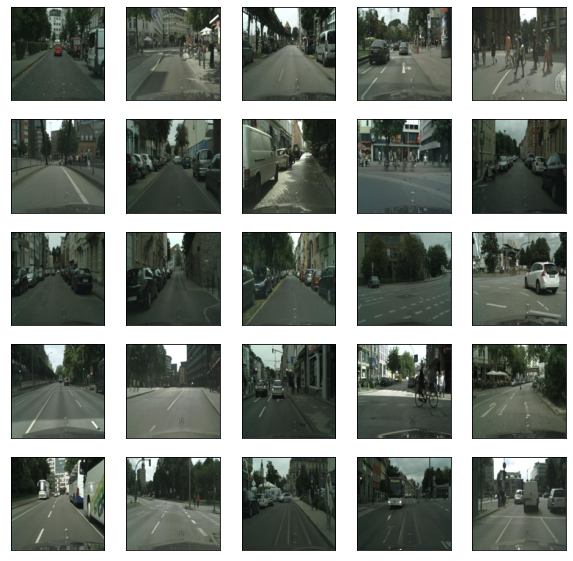

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

In [11]:
import tensorflow as tf

In [12]:
def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
  
    if(conv_type == 'ds'):
        x = tf.keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)
    else:
        x = tf.keras.layers.Conv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)  
  
    x = tf.keras.layers.BatchNormalization()(x)
  
    if (relu):
        x = tf.keras.activations.relu(x)
  
    return x

In [13]:
input_layer = tf.keras.layers.Input(shape=(128, 128, 3), name = 'input_layer')

In [14]:
lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

In [15]:
def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    
    
    tchannel = tf.keras.backend.int_shape(inputs)[-1] * t

    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

In [16]:
def bottleneck_block(inputs, filters, kernel, t, strides, n):
  x = _res_bottleneck(inputs, filters, kernel, t, strides)
  
  for i in range(1, n):
    x = _res_bottleneck(x, filters, kernel, t, 1, True)

  return x

In [17]:
def pyramid_pooling_block(input_tensor, bin_sizes):
  concat_list = [input_tensor]
  w = 64
  h = 32

  for bin_size in bin_sizes:
    x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same')(x)
    x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w,h)))(x)

    concat_list.append(x)

  return tf.keras.layers.concatenate(concat_list)

In [18]:
gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)

In [19]:
ff_layer1 = conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

In [20]:
ff_layer2 = tf.keras.layers.UpSampling2D((4, 4))(gfe_layer)
ff_layer2 = tf.keras.layers.DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same')(ff_layer2)
ff_layer2 = tf.keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = tf.keras.activations.relu(ff_layer2)
ff_layer2 = tf.keras.layers.Conv2D(128, 1, 1, padding='same', activation=None)(ff_layer2)

In [21]:
ff_final = tf.keras.layers.add([ff_layer1, ff_layer2])
ff_final = tf.keras.layers.BatchNormalization()(ff_final)
ff_final = tf.keras.activations.relu(ff_final)

In [22]:
classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff_final)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)


classifier = conv_block(classifier, 'conv', 3, (1, 1), strides=(1, 1), padding='same', relu=False)

classifier = tf.keras.layers.Dropout(0.3)(classifier)

classifier = tf.keras.layers.UpSampling2D((8, 8))(classifier)
classifier = tf.keras.activations.softmax(classifier)

In [24]:
fast_scnn = tf.keras.Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')
optimizer = tf.keras.optimizers.SGD(momentum=0.9, lr=0.045)
fast_scnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [25]:
fast_scnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                          

In [ ]:
tf.keras.utils.plot_model(fast_scnn, show_layer_names=True, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [26]:
history = fast_scnn.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
42/42 [==============================] - 45s 958ms/step - loss: 1.2222 - accuracy: 0.4284 - val_loss: 1.1287 - val_accuracy: 0.5798
Epoch 2/100
42/42 [==============================] - 40s 944ms/step - loss: 1.2367 - accuracy: 0.4613 - val_loss: 1.1295 - val_accuracy: 0.5798
Epoch 3/100
42/42 [==============================] - 40s 947ms/step - loss: 1.3092 - accuracy: 0.4698 - val_loss: 1.1291 - val_accuracy: 0.5798
Epoch 4/100
42/42 [==============================] - 40s 948ms/step - loss: 1.3677 - accuracy: 0.4717 - val_loss: 1.1275 - val_accuracy: 0.5470
Epoch 5/100
42/42 [==============================] - 40s 946ms/step - loss: 1.4471 - accuracy: 0.4726 - val_loss: 1.1254 - val_accuracy: 0.5319
Epoch 6/100
42/42 [==============================] - 40s 948ms/step - loss: 1.5217 - accuracy: 0.4765 - val_loss: 1.1235 - val_accuracy: 0.5684
Epoch 7/100
42/42 [==============================] - 40s 957ms/step - loss: 1.5774 - accuracy: 0.4688 - val_loss: 1.1323 - val_accuracy:

In [42]:
df = pd.DataFrame(history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.222212,0.428408,1.128715,0.579831
1,1.236721,0.461335,1.129452,0.579831
2,1.309248,0.469792,1.129057,0.579831
3,1.367674,0.471684,1.127452,0.547034
4,1.447054,0.472633,1.125405,0.531910
...,...,...,...,...
95,16.607347,0.447823,1.612057,0.594153
96,16.859287,0.449316,1.780201,0.522970
97,17.297951,0.439048,1.568107,0.470356
98,17.281244,0.430145,1.543139,0.479230


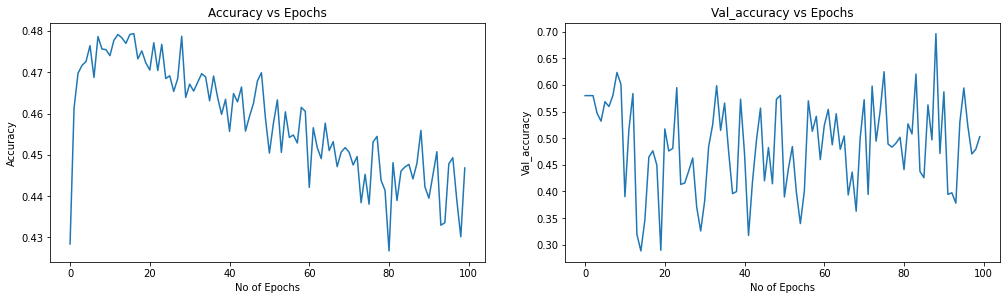

In [28]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(df.accuracy)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Epochs')

axes[1].plot(df.val_accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Val_accuracy')
axes[1].set_title('Val_accuracy vs Epochs')
plt.show()

In [44]:
probability_model = tf.keras.Sequential([fast_scnn, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)
predictions[0].shape

(128, 128, 3)

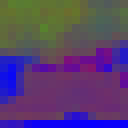

In [45]:
tf.keras.preprocessing.image.array_to_img(
    predictions[0]
)


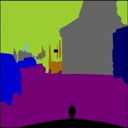

In [39]:
tf.keras.preprocessing.image.array_to_img(
    y_test[0]
)

In [40]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [41]:
print(iou_coef(y_test, predictions))

tf.Tensor(0.31252956, shape=(), dtype=float32)


In [51]:
from statistics import mean

avg = mean(df['accuracy'])

print("The average is ", avg)

The average is  0.45836203008890153


In [52]:
from statistics import mean

avg = mean(df['val_accuracy'])

print("The average is ", avg)

The average is  0.4858311793208122
